In [51]:
# pip install PyPortfolioOpt

In [52]:
import pandas as pd
import numpy as np
import yfinance as yf
import warnings
warnings.filterwarnings('ignore')

In [53]:
#%% extract data
start_date = '2024-01-01'
split_date = '2024-06-30'
end_date = '2024-07-31'
tickers = ['AAPL','MSFT','NVDA','GOOG','AMZN','META','TSM','LLY','TSLA','AVGO']

train = yf.download(tickers, start=start_date, end=split_date)['Close']
test = yf.download(tickers, start=split_date, end=end_date)['Close']
test_ret = test.pct_change()

[*********************100%%**********************]  10 of 10 completed
[*********************100%%**********************]  10 of 10 completed


In [54]:
# calculate expected returns and covariance matrix
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage

mu = mean_historical_return(train)
S = CovarianceShrinkage(train).ledoit_wolf()

In [55]:
# calculate weights of efficient portfolio
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import objective_functions

ef = EfficientFrontier(mu, S)
weights = ef.max_sharpe()
weights = ef.clean_weights()
print(weights)

OrderedDict([('AAPL', 0.0), ('AMZN', 0.0), ('AVGO', 0.0), ('GOOG', 0.04042), ('LLY', 0.19398), ('META', 0.0), ('MSFT', 0.0), ('NVDA', 0.76559), ('TSLA', 0.0), ('TSM', 0.0)])


In [56]:
# using these weights to indicate how many shares of each asset to buy, assuming portfolio of $1,000,000
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices

latest_prices = get_latest_prices(train)
da = DiscreteAllocation(weights, latest_prices, total_portfolio_value=1000000)
allocation, leftover = da.lp_portfolio()
print(allocation)

{'GOOG': 221, 'LLY': 214, 'NVDA': 6197}


In [57]:
def rough_weight_ret(data, weights):
    # Make a copy of the original data
    data_copy = data.copy()

    # calculate returns of test portfolio, using rough weights
    for ticker, weight in weights.items():
        if ticker in data_copy.columns:
            data_copy[ticker] = data_copy[ticker] * weight

    data_copy['trade'] = data_copy.sum(axis=1)
    data_copy['return'] = data.sum(axis=1)/10
    
    # convert to log returns
    data_copy['trade'] = np.log( 1 + data_copy['trade'])
    data_copy['return'] = np.log( 1 + data_copy['return'])

    # calculate returns over test period
    annual_ret = np.exp(data_copy['trade'].sum())-1
    print('------using rough weights------')
    print('regular return: ',annual_ret)

    # calculate standard deviation over same period
    annual_std = (np.exp(data_copy['trade'])-1).std()
    print('regular std: ', annual_std)

    # calculate sharpe ratio
    sr = annual_ret/ annual_std
    print("Sharpe Ratio is: ", sr)
    print('--------------------------------')
    
    data_copy.to_csv('C:\\Users\\dawei\\Dropbox\\NUS\\DSA5205\\project\\MVO\\MVO.csv')
    data_copy[["return","trade"]].cumsum().plot(figsize=(10,3))

------using rough weights------
regular return:  -0.15408590529589916
regular std:  0.028757038631780227
Sharpe Ratio is:  -5.358197944819478
--------------------------------


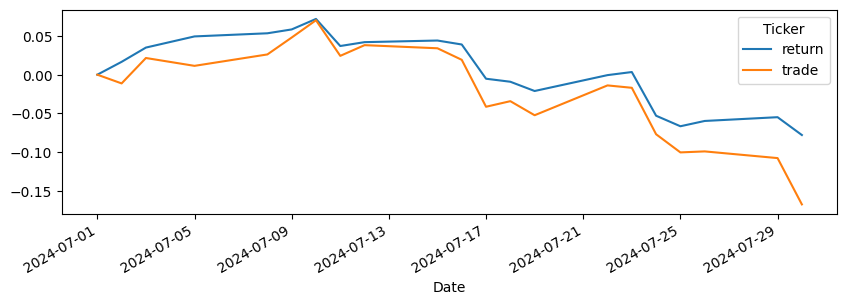

In [58]:
rough_weight_ret(test_ret, weights)
#discrete_ret(test, allocation)

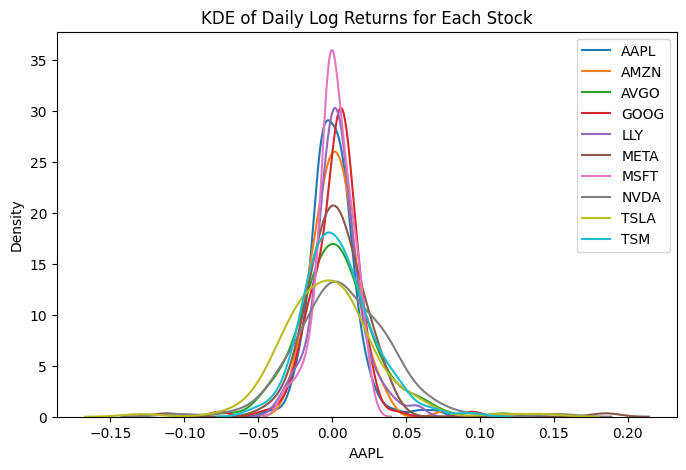

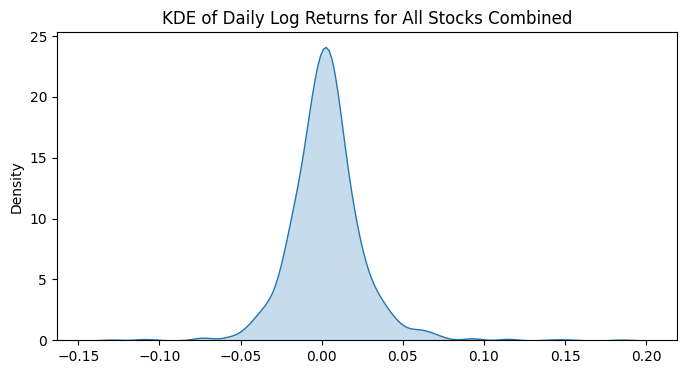

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns

# plot KDE of log returns of each stock
log_returns = np.log(train / train.shift(1)).dropna()

plt.figure(figsize=(8, 5))
for column in log_returns.columns:
    sns.kdeplot(log_returns[column], label=column, fill=False)
plt.title('KDE of Daily Log Returns for Each Stock')
plt.legend()
plt.show()

# plot KDE of combined log returns
combined_log_returns = log_returns.stack().reset_index(level=1, drop=True)

plt.figure(figsize=(8, 4))
sns.kdeplot(combined_log_returns, fill=True)
plt.title('KDE of Daily Log Returns for All Stocks Combined')
plt.show()

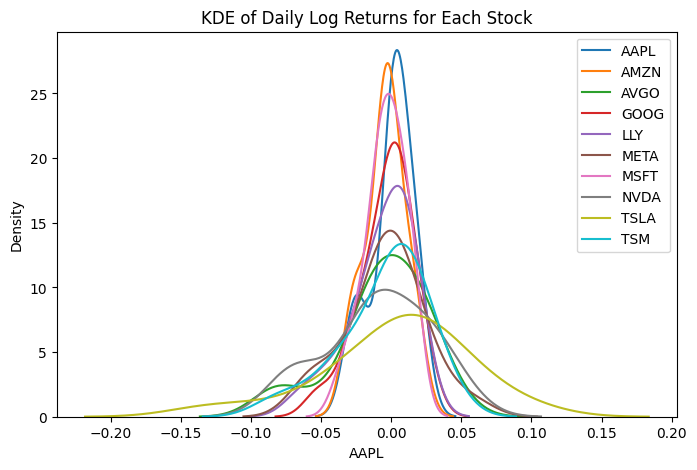

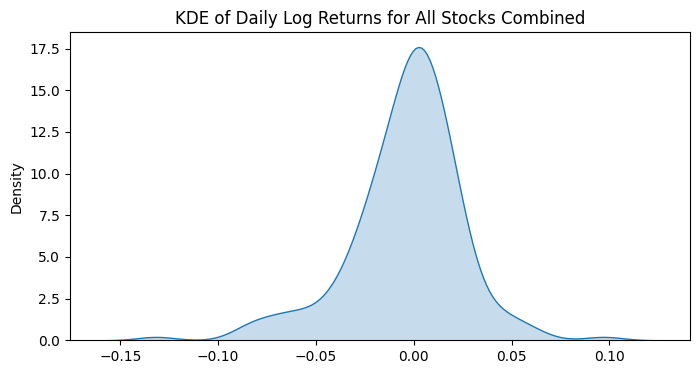

In [60]:
# plot KDE of log returns of each stock
log_returns_test = np.log(test / test.shift(1)).dropna()

plt.figure(figsize=(8, 5))
for column in log_returns_test.columns:
    sns.kdeplot(log_returns_test[column], label=column, fill=False)
plt.title('KDE of Daily Log Returns for Each Stock')
plt.legend()
plt.show()

# plot KDE of combined log returns
combined_log_returns_test = log_returns_test.stack().reset_index(level=1, drop=True)

plt.figure(figsize=(8, 4))
sns.kdeplot(combined_log_returns_test, fill=True)
plt.title('KDE of Daily Log Returns for All Stocks Combined')
plt.show()

      KS Statistic   P-Value
AAPL      0.229675  0.275316
AMZN      0.239024  0.235084
AVGO      0.158537  0.718178
GOOG      0.234146  0.256105
LLY       0.288618  0.091267
META      0.187805  0.510632
MSFT      0.271138  0.130298
NVDA      0.291057  0.086389
TSLA      0.272358  0.127128
TSM       0.217480  0.334338


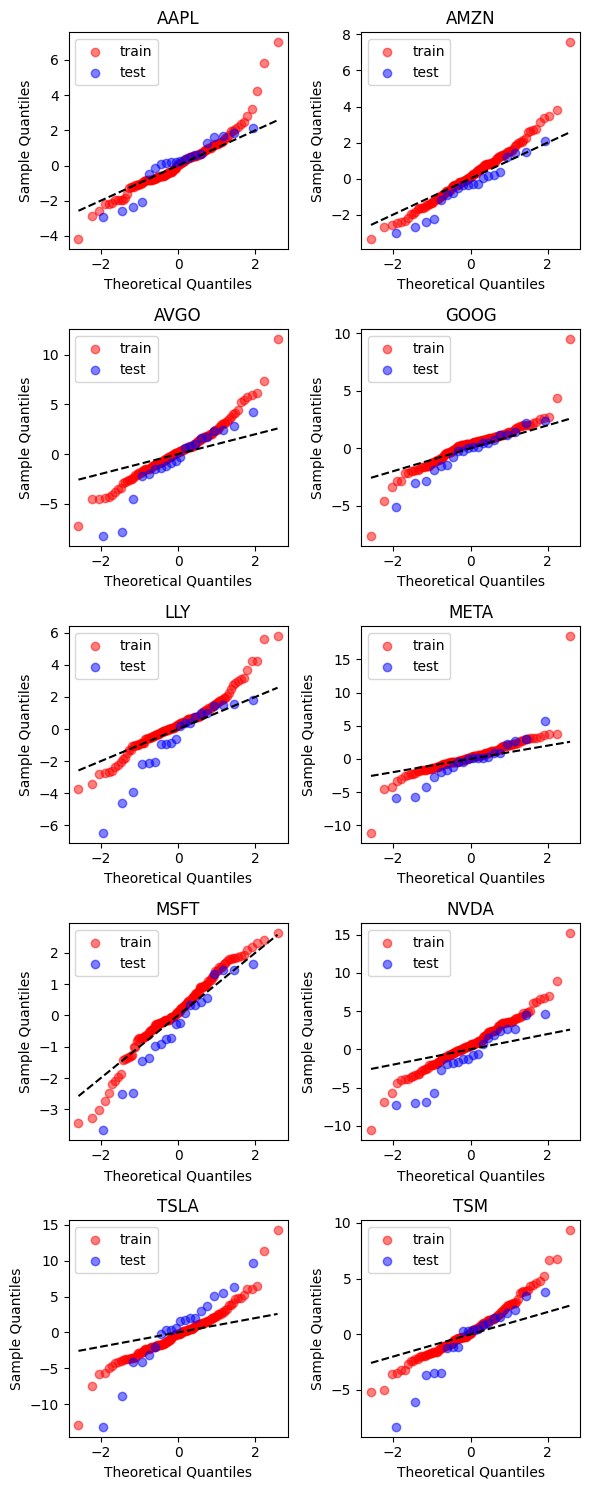

In [63]:
from scipy import stats

# Perform 2 sample kolmogorov-smirnov test for each stock. Same distribution if p-value above eg 0.01 or 0.05 
ks_results = {}
for column in log_returns.columns:
    stat, p_value = stats.ks_2samp(log_returns[column].dropna(), log_returns_test[column].dropna())
    ks_results[column] = {'KS Statistic': stat, 'P-Value': p_value}
ks_results_df = pd.DataFrame(ks_results).T
print(ks_results_df)

# Plot Q-Q plots to compare 
#df_t = 50 # set df_t to n-1 instead
plt.figure(figsize=(6, 15))
for i, column in enumerate(log_returns.columns, 1):
    plt.subplot(5, 2, i)
    (osm, osr), (slope, intercept, r) = stats.probplot(log_returns[column].dropna(), dist="t", sparams=(len(log_returns)-1,))
    plt.scatter(osm, osr*100, color='red', alpha=0.5, label='train')
    (osm_, osr_), (slope_, intercept_, r_) = stats.probplot(log_returns_test[column].dropna(), dist="t", sparams=(len(log_returns_test)-1,))
    plt.scatter(osm_, osr_*100, color='blue', alpha=0.5, label='test')
    min_val = min(osm.min(), osr.min(), osm_.min(), osr_.min())
    max_val = max(osm.max(), osr.max(), osm_.max(), osr_.max())
    plt.plot([min_val, max_val], [min_val, max_val], color='black', linestyle='--')
    plt.title(f'{column}')
    plt.xlabel('Theoretical Quantiles')
    plt.ylabel('Sample Quantiles')
    plt.legend()
plt.tight_layout()
plt.show()